# Data Processing

## Import Libraries

In [ ]:
! pip install tensorflow_addons
! pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 7.7 MB/s eta 0:00:00


In [ ]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay
)
from scikitplot.metrics import plot_roc

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Hyper Parameters

In [ ]:
class CFG:
    # DATA
    BUFFER_SIZE = 128
    BATCH_SIZE = 16
    HEIGHT = 224
    WIDTH = 224
    NUM_CLASSES = 4
    SEED = 42

    # AUGMENTATION
    IMAGE_SIZE = 224
    PATCH_SIZE = 16
    NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

    # OPTIMIZER
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0001

    # TRAINING
    EPOCHS = 100

    # ARCHITECTURE
    INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
    LAYER_NORM_EPS = 1e-6
    TRANSFORMER_LAYERS = 8
    PROJECTION_DIM = 64
    NUM_HEADS = 2
    TRANSFORMER_UNITS = [
        PROJECTION_DIM * 2,
        PROJECTION_DIM,
    ]
    MLP_HEAD_UNITS = [1024, 512]

## Data Handling and loading

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/'
# DATASET_PATH = '/content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/ALL_Segmented'

In [ ]:
# Generate a summary of the dataset
print('DATASET SUMMARY')
print('========================\n')
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
print('\n========================')

DATASET SUMMARY

There are 4 directories and 0 images in /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/
There are 0 directories and 804 images in /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/Pro
There are 0 directories and 985 images in /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/Early
There are 0 directories and 963 images in /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/Pre
There are 0 directories and 504 images in /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/Benign



In [ ]:
image_path = []
for _dir in os.listdir(DATASET_PATH):
  _path = os.path.join(DATASET_PATH, _dir)
  for _img in os.listdir(_path):
    image_path.append(os.path.join(_path, _img))
image_path = sorted(image_path)

In [ ]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })

    # Generate label encodings
    # df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'malignant' else 1, axis=1)

    # Shuffle and return df
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [ ]:
label = image_path[0].split('/')[-2:][0]
label

'Benign'

In [ ]:
images = build_df(image_path, generate_labels(image_path))

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(images['label'])
images['label_encoding'] = le.transform(images['label'])

In [ ]:
sorted(images['label'].unique())

['Benign', 'Early', 'Pre', 'Pro']

In [ ]:
def _load(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)

    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS5)

    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.

    # Return image
    return image

## View Sample

In [ ]:
def view_sample(image, label, color_map='rgb', fig_size=(6, 6)):
    plt.figure(figsize=fig_size)

    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(tf.image.rgb_to_grayscale(image), cmap=color_map)

    plt.title(f'Label: {label}', fontsize=16)
    return

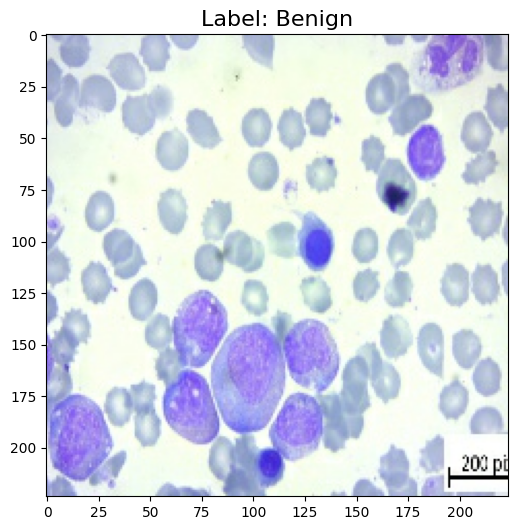

In [ ]:
# Select random sample from train_df
idx = random.sample(images.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(images.image_path[idx]), images.label[idx]

# View the random sample
view_sample(sample_image, sample_label, color_map='rgb')

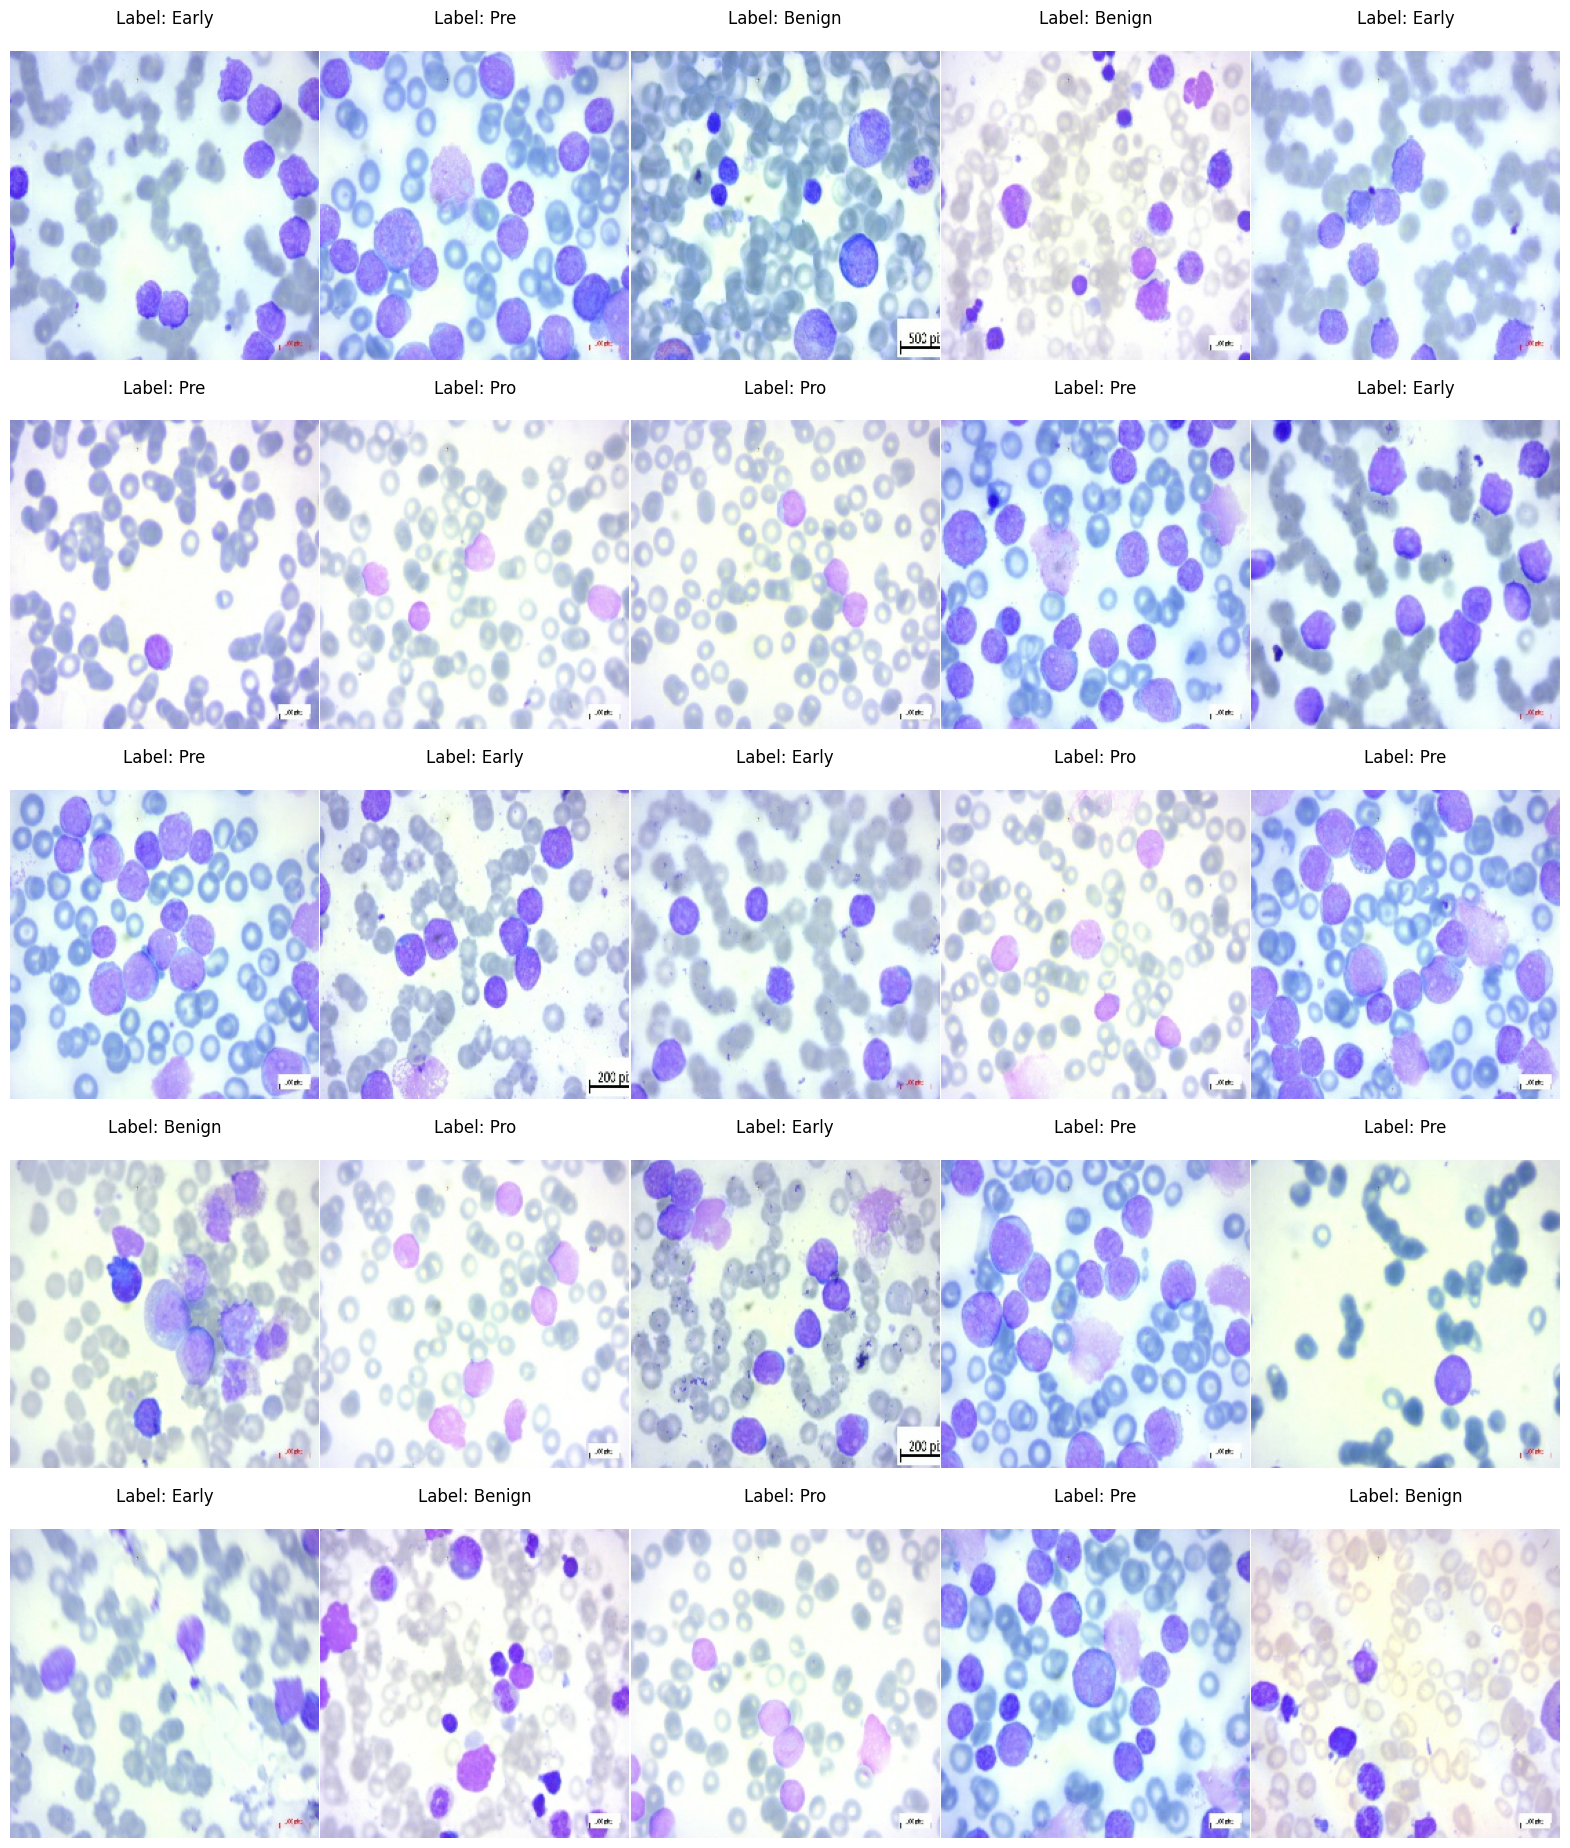

In [ ]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1

    idx = random.sample(df.index.to_list(), count)
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}', pad=20)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.005, hspace=0)

        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]))
        else:
            plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])), cmap=color_map)

    plt.show()

    return

# view_mulitiple_samples(images, _load,
#                        count=25, color_map='rgb',
#                        fig_size=(20, 24))

## Split train, valid, test

In [ ]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(images['image_path'], images['label_encoding'], test_size=0.2, random_state= CFG.SEED)
valid_x, test_x, valid_y, test_y = train_test_split(valid_x, valid_y, test_size=0.5, random_state=CFG.SEED)

## View Dataset Distribution

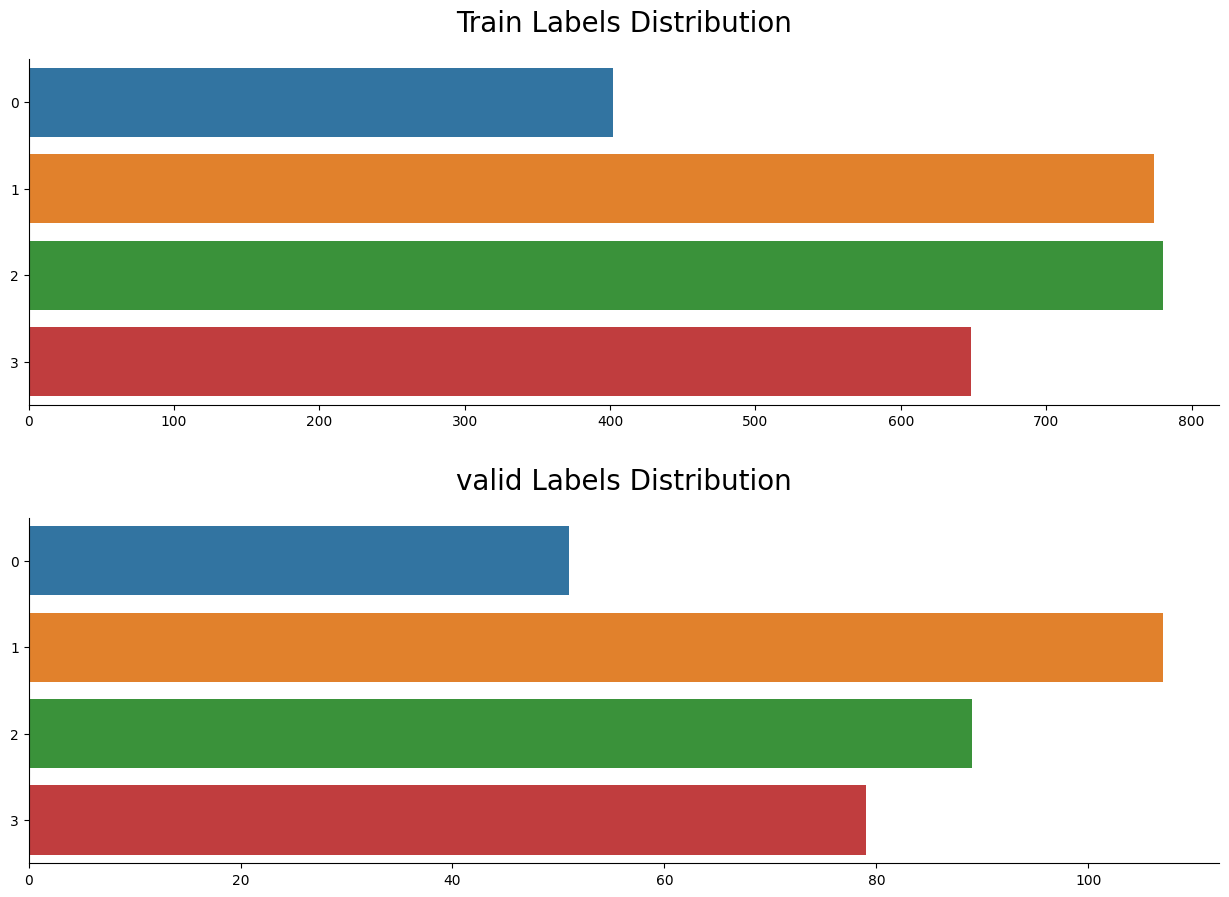

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20, pad=20)
train_distribution = train_y.value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Test Labels Distribution
ax2.set_title('valid Labels Distribution', fontsize=20, pad=20)
test_distribution = valid_y.value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax2);

sns.despine();

## Augmentation

In [ ]:
# Build augmentation layer
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.SEED),
    layers.RandomContrast(0.4, seed=CFG.SEED),

], name='augmentation_layer')

(-0.5, 223.5, 223.5, -0.5)

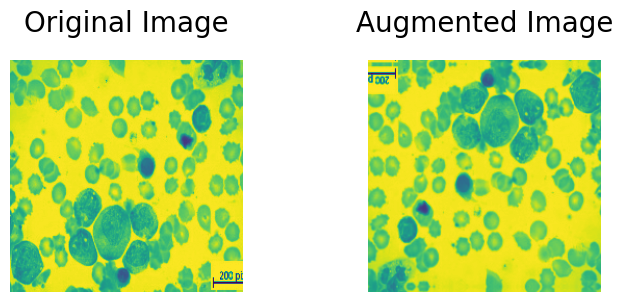

In [ ]:
image = tf.image.rgb_to_grayscale(sample_image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20, pad=20)
ax1.imshow(image, cmap='viridis');
ax1.axis('off')

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20, pad=20)
ax2.imshow(augmentation_layer(image), cmap='viridis');
ax2.axis('off')

## Input Pipeline

In [ ]:
def encode_labels(labels, encode_depth=CFG.NUM_CLASSES):
    return tf.one_hot(labels, depth=encode_depth).numpy()

def create_pipeline(X, y,  load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    '''
    Generates an input pipeline using the tf.data API given a Pandas DataFrame and image loading function.

    @params
        - X: X contain images path
        - y: y contain the label of corosponding X
        - load_function: (function) -> function used to load images given their paths
        - augment: (bool) -> condition for applying augmentation
        - batch_size: (int) -> size for batched (default=32)
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (str) -> cache path for caching data, data is not cached when None (default=None)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)

    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    # Get image paths and labels from DataFrame
    image_paths = X
    image_labels = encode_labels(y)
    AUTOTUNE = tf.data.AUTOTUNE

    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))

    # Map augmentation layer and load function to dataset inputs if augment is True
    # Else map only the load function
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)

    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    # Apply batching
    ds = ds.batch(batch_size)

    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)

    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    # Return the dataset
    return ds

In [ ]:
# Generate Train Input Pipeline
train_ds = create_pipeline(train_x, train_y, _load, augment=True,
                           batch_size=CFG.BATCH_SIZE,
                           shuffle=False, prefetch=True)

# Generate Validation Input Pipeline
val_ds = create_pipeline(valid_x, valid_y, _load,
                         batch_size=CFG.BATCH_SIZE,
                         shuffle=False, prefetch=False)

# Generate Test Input Pipeline
test_ds = create_pipeline(test_x, test_y, _load,
                          batch_size=CFG.BATCH_SIZE,
                          shuffle=False, prefetch=False)

In [ ]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')


Train Input Data Pipeline:

 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


# Model Running

## Implement Shifted Patch Tokenization

In [ ]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=CFG.IMAGE_SIZE,
        patch_size=CFG.PATCH_SIZE,
        num_patches=CFG.NUM_PATCHES,
        projection_dim=CFG.PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=CFG.LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [ ]:
"""
# Get a random image from the training dataset
# and resize the image
image = _load(images.image_path[idx])

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(CFG.IMAGE_SIZE, CFG.IMAGE_SIZE)
)
# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (CFG.PATCH_SIZE, CFG.PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (CFG.PATCH_SIZE, CFG.PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

"""

'\n# Get a random image from the training dataset\n# and resize the image\nimage = _load(images.image_path[idx])\n\nresized_image = tf.image.resize(\n    tf.convert_to_tensor([image]), size=(CFG.IMAGE_SIZE, CFG.IMAGE_SIZE)\n)\n# Vanilla patch maker: This takes an image and divides into\n# patches as in the original ViT paper\n(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image)\n(token, patch) = (token[0], patch[0])\nn = patch.shape[0]\ncount = 1\nplt.figure(figsize=(4, 4))\nfor row in range(n):\n    for col in range(n):\n        plt.subplot(n, n, count)\n        count = count + 1\n        image = tf.reshape(patch[row][col], (CFG.PATCH_SIZE, CFG.PATCH_SIZE, 3))\n        plt.imshow(image)\n        plt.axis("off")\nplt.show()\n\n# Shifted Patch Tokenization: This layer takes the image, shifts it\n# diagonally and then extracts patches from the concatinated images\n(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image)\n(token, patch) = (token[0], patch[

## Implement the patch encoding layer

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=CFG.NUM_PATCHES, projection_dim=CFG.PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

## Implement Attention

In [ ]:
import math

In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

## Multi Layer Perception

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(CFG.NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

## Build VIT

In [ ]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=CFG.INPUT_SHAPE)
    # Augment data.
    augmented = augmentation_layer(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(CFG.TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=CFG.NUM_HEADS, key_dim=CFG.PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=CFG.NUM_HEADS, key_dim=CFG.PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=CFG.TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=CFG.MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(CFG.NUM_CLASSES)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model, model_name, csv_name):
    paths = '/content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Model'
    model_path = os.path.join(paths+"/files/", model_name)
    csv_path = os.path.join(paths+"/files/", csv_name)
    #--------------------------------------------
    from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
    #--------------------------------------------------------
    # Define Early Stopping Callback
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True)

    # (Optional) Define Reduce Learning Rate Callback
    # reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss',
    #     patience=6,
    #     factor=0.1,
    #     verbose=1)

    # Define Callbacks and Metrics lists
    CALLBACKS = [
            ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
            CSVLogger(csv_path),
            EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
        ]

    METRICS = ['accuracy']

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False,label_smoothing=0.0,axis=-1,reduction="auto",name="categorical_crossentropy",
    ),
        optimizer=tfa.optimizers.AdamW(learning_rate=CFG.LEARNING_RATE, weight_decay=CFG.WEIGHT_DECAY),
        metrics=METRICS
    )

    # Train the model
    print(f'Training {model.name}.')
    print(f'Train on {len(train_x)}, {len(train_y)} samples, validate on {len(valid_x)}, {len(valid_y)} samples.')
    print('----------------------------------')


    history = model.fit(
        train_ds,
        validation_data=val_ds,
        batch_size=CFG.BATCH_SIZE,
        epochs=CFG.EPOCHS,
        callbacks=CALLBACKS,
    )
    return history


In [ ]:
# Run experiments with the vanilla ViT
vit = create_vit_classifier(vanilla=True)
# history = run_experiment(vit, 'vit_model.h5', 'vit.csv')

Training model_3.
Train on 2604, 2604 samples, validate on 326, 326 samples.
----------------------------------
Epoch 1/100
163/163 [==============================] - ETA: 0s - loss: 7.3326 - accuracy: 0.2227
Epoch 1: val_loss improved from inf to 6.92188, saving model to /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Model/files/vit_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 78s 397ms/step - loss: 7.3326 - accuracy: 0.2227 - val_loss: 6.9219 - val_accuracy: 0.1564 - lr: 0.0010
Epoch 2/100
163/163 [==============================] - ETA: 0s - loss: 7.5206 - accuracy: 0.1540
Epoch 2: val_loss did not improve from 6.92188
163/163 [==============================] - 34s 211ms/step - loss: 7.5206 - accuracy: 0.1540 - val_loss: 6.9219 - val_accuracy: 0.1564 - lr: 0.0010
Epoch 3/100
163/163 [==============================] - ETA: 0s - loss: 7.5949 - accuracy: 0.1559
Epoch 3: val_loss did not improve from 6.92188
163/163 [==============================] - 31s 193ms/step - loss: 7.5949 - accuracy: 0.1559 - val_loss: 6.9219 - val_accuracy: 0.1564 - lr: 0.0010
Epoch 4/100
163/163 [==============================] - ETA: 0s - loss: 7.7619 - accuracy: 0.1559
Epoch 4: val_loss did not improve from 6.92188
163/163 [==============================] - 36s 219ms/step - loss: 7.7619 - accuracy: 0.1559 - val_loss: 6.9219 - val_accuracy: 

In [ ]:
# Run experiments with the Shifted Patch Tokenization and
# Locality Self Attention modified ViT
vit_sl = create_vit_classifier(vanilla=False)
history_sl = run_experiment(vit_sl, 'vit_sl_model.h5', 'vit_sl.csv')

Training model_4.
Train on 2604, 2604 samples, validate on 326, 326 samples.
----------------------------------
Epoch 1/100
163/163 [==============================] - ETA: 0s - loss: 6.9719 - accuracy: 0.2154
Epoch 1: val_loss improved from inf to 6.42746, saving model to /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Model/files/vit_sl_model.h5


ValueError: ignored

# Performace Evaluation (VIT)

In [ ]:
# Generate model probabilities and associated predictions
test_probabilities = vit.predict(val_ds, verbose=1)
test_predictions = tf.argmax(test_probabilities, axis=1)

21/21 [==============================] - 3s 77ms/step


In [ ]:
def plot_training_curves(history, ):

    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

    sns.despine();

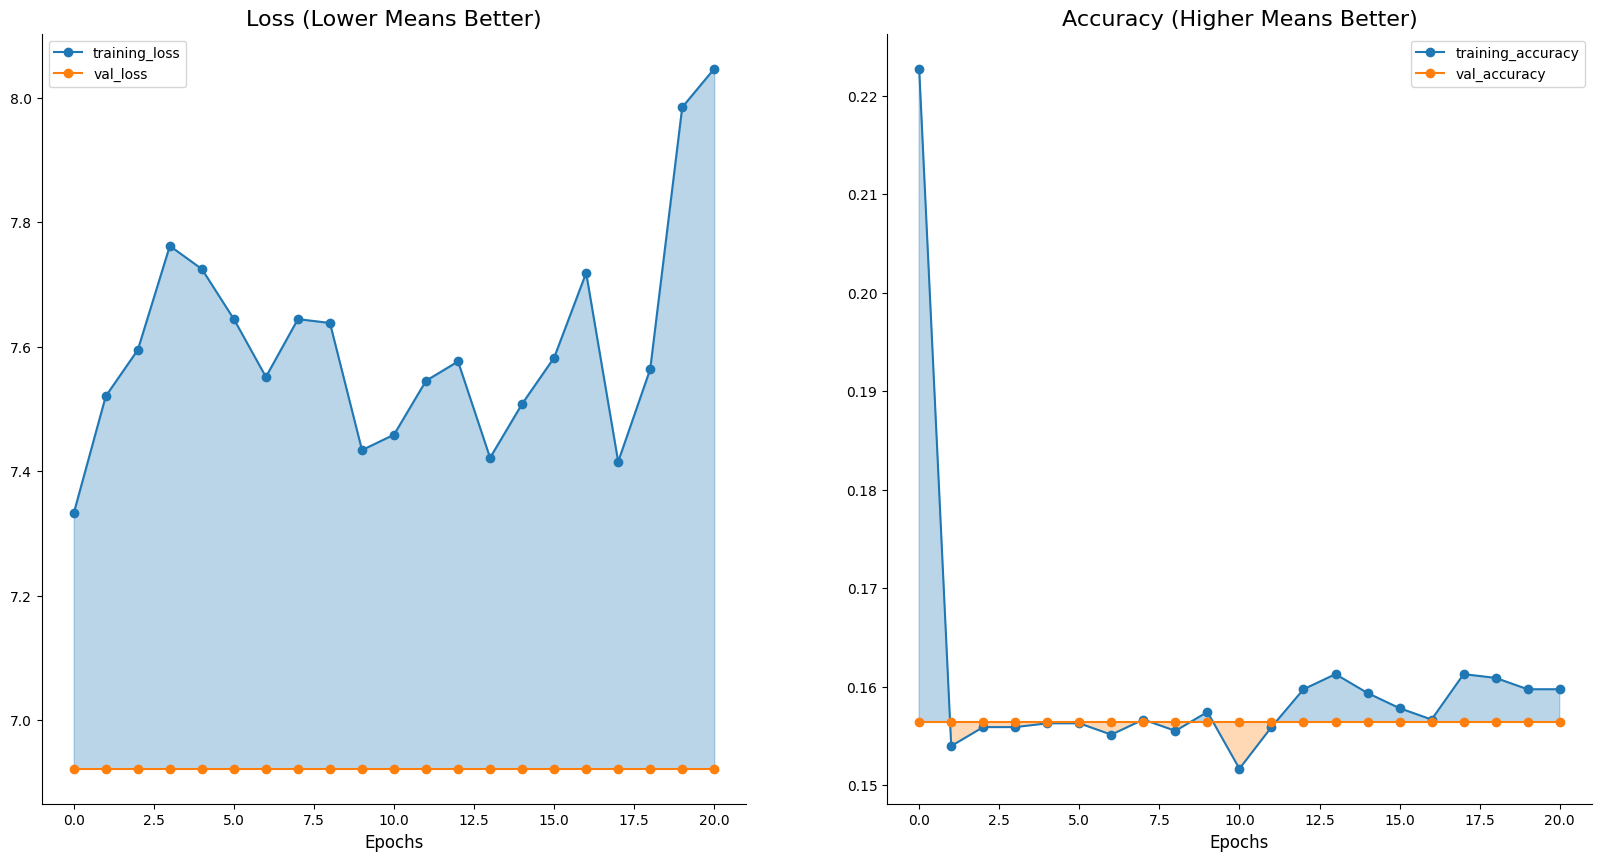

In [ ]:
# plot vit model training history
plot_training_curves(history)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)

    # Plot confusion matrix
    plt.show()

    return

## Validation Sets

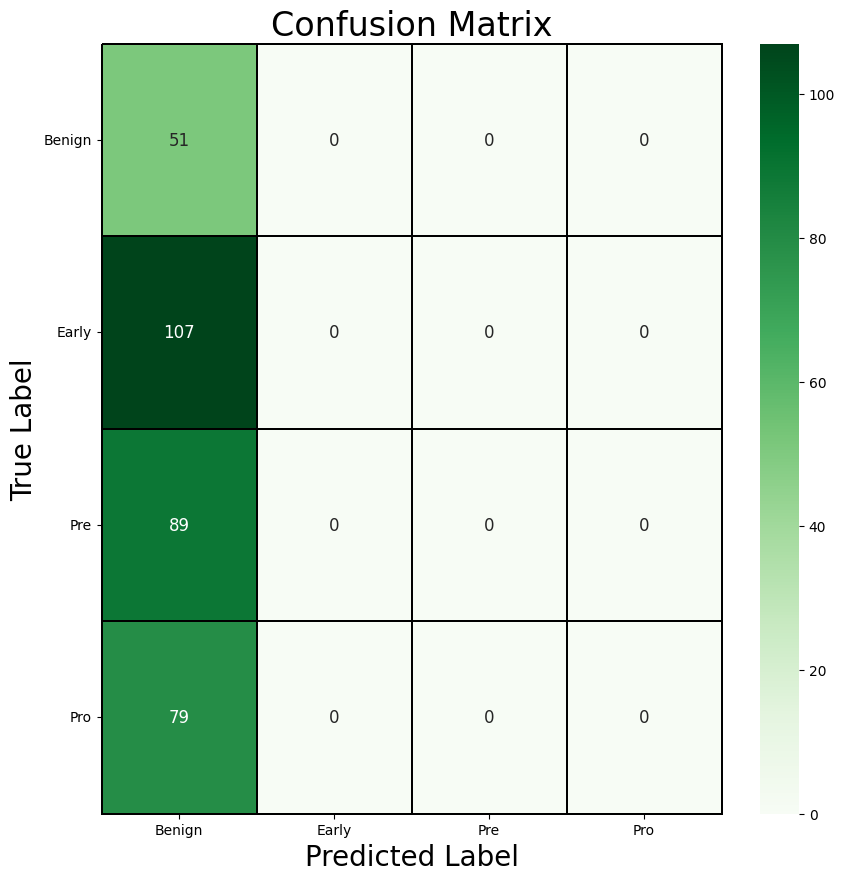

In [ ]:
class_names = ['Benign', 'Early', 'Pre', 'Pro']

plot_confusion_matrix(
    valid_y,
    test_predictions,
    figsize=(10, 10),
    classes=class_names)

In [ ]:
plot_roc(valid_y,
         test_probabilities,
         figsize=(8, 8), title_fontsize='large');

In [ ]:
print(classification_report(valid_y,
                            test_predictions,
                            target_names=class_names))

In [ ]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):

    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                 y_pred,
                                                                                 average="weighted")
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)

    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')

    preformance_scores = {
        'accuracy_score': model_accuracy,
        'precision_score': model_precision,
        'recall_score': model_recall,
        'f1_score': model_f1,
        'matthews_corrcoef': model_matthews_corrcoef
    }
    return preformance_scores

In [ ]:
# Record CCT model performance scores
performance = generate_preformance_scores(valid_y,
                                              test_predictions,
                                              test_probabilities)

## Test Sets

In [ ]:
# Generate model probabilities and associated predictions
test_probabilities = vit.predict(test_ds, verbose=1)
test_predictions = tf.argmax(test_probabilities, axis=1)

In [ ]:
class_names = ['Benign', 'Early', 'Pre', 'Pro']

plot_confusion_matrix(
    test_y,
    test_predictions,
    figsize=(10, 10),
    classes=class_names)

In [ ]:
print(classification_report(test_y,
                            test_predictions,
                            target_names=class_names))

In [ ]:
# Record CCT model performance scores
cct_performance = generate_preformance_scores(test_y,
                                              test_predictions,
                                              test_probabilities)

# Performace Evaluaton (VIT SL)

In [ ]:
test_probabilities_sl = vit_sl.predict(val_ds, verbose=1)
test_predictions_sl = tf.argmax(test_probabilities_sl, axis=1)

In [ ]:
plot_training_curves(history_sl)

## Validation Sets

In [ ]:
class_names = ['Benign', 'Early', 'Pre', 'Pro']

plot_confusion_matrix(
    valid_y,
    test_predictions_sl,
    figsize=(10, 10),
    classes=class_names)

In [ ]:
plot_roc(valid_y,
         test_probabilities_sl,
         figsize=(8, 8), title_fontsize='large');

In [ ]:
print(classification_report(valid_y,
                            test_predictions_sl,
                            target_names=class_names))

In [ ]:
# Record CCT model performance scores
performance = generate_preformance_scores(valid_y,
                                              test_predictions_sl,
                                              test_probabilities_sl)

## Test Sets

In [ ]:
# Generate model probabilities and associated predictions
test_probabilities_sl = vit_sl.predict(test_ds, verbose=1)
test_predictions_sl = tf.argmax(test_probabilities_sl, axis=1)

In [ ]:
class_names = ['Benign', 'Early', 'Pre', 'Pro']

plot_confusion_matrix(
    test_y,
    test_predictions_sl,
    figsize=(10, 10),
    classes=class_names)

In [ ]:
print(classification_report(test_y,
                            test_predictions_sl,
                            target_names=class_names))

In [ ]:
# Record CCT model performance scores
cct_performance = generate_preformance_scores(test_y,
                                              test_predictions_sl,
                                              test_probabilities_sl)